In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
from collections import Counter
%matplotlib inline

In [2]:
user_clustid = pd.read_csv('user_clustid_k25.csv')
book_year = pd.read_csv('book_year_1tag.csv')
ratings_books = pd.read_csv('ratings_books_u80_b10.csv')

In [3]:
listbooks_ratings = list(set(ratings_books['book_id_gr']))
listbooks_ratings_idx = list(set(ratings_books['book_idx']))

In [4]:
listbooks_year = list(set(book_year['book_id']))
len(listbooks_year)

92803

In [5]:
ratings_books.head()

,user_id,is_read,rating,is_reviewed,book_id_gr,user_counts,book_counts,user_idx,book_idx
0,1073,1,3,1,47970,146,157,0,624
1,1073,1,4,1,304687,146,49,0,1867
2,1073,1,3,1,149267,146,1954,0,1322
3,1073,1,3,1,140098,146,136,0,1276
4,1073,1,3,1,1773616,146,71,0,3473


In [46]:
book_year.head()

,average_rating,book_id,popular_shelves,publication_year
0,3.48,7203847,horror,2010.0
1,4.04,12182387,young-adult,NaN
2,3.80,20135365,dystopia,NaN
3,3.43,780918,historical-fiction,NaN
4,3.55,780912,historical-fiction,2005.0


In [6]:
book_year.rename(columns={'book_id':'book_id_gr', 'publication_year':'pub_year'}, inplace=True)

In [7]:
book_year.head(3)

,average_rating,book_id_gr,popular_shelves,pub_year
0,3.48,7203847,horror,2010.0
1,4.04,12182387,young-adult,NaN
2,3.80,20135365,dystopia,NaN


In [8]:
len(listbooks_ratings), max(listbooks_ratings_idx)

(10268, 10267)

In [9]:
# Get books publication year from books_sci-fi, matching book_id from rated and reviewed data
ratings_book_year = ratings_books[ratings_books['book_id_gr'].isin(listbooks_year)]

In [10]:
len(ratings_book_year)

65897

In [11]:
ratings_book_year = pd.merge(ratings_books, book_year, on='book_id_gr',)

In [12]:
ratings_book_year.head()

,user_id,is_read,rating,is_reviewed,book_id_gr,user_counts,book_counts,user_idx,book_idx,average_rating,popular_shelves,pub_year
0,1073,1,3,1,47970,146,157,0,624,3.9,fantasy,2002.0
1,17408,1,3,1,47970,215,157,51,624,3.9,fantasy,2002.0
2,54366,1,4,1,47970,111,157,130,624,3.9,fantasy,2002.0
3,91057,1,4,1,47970,81,157,195,624,3.9,fantasy,2002.0
4,98248,1,4,1,47970,139,157,210,624,3.9,fantasy,2002.0


In [13]:
ratings_books.head()

,user_id,is_read,rating,is_reviewed,book_id_gr,user_counts,book_counts,user_idx,book_idx
0,1073,1,3,1,47970,146,157,0,624
1,1073,1,4,1,304687,146,49,0,1867
2,1073,1,3,1,149267,146,1954,0,1322
3,1073,1,3,1,140098,146,136,0,1276
4,1073,1,3,1,1773616,146,71,0,3473


In [14]:
book_year[book_year['book_id_gr'] == 47970]

,average_rating,book_id_gr,popular_shelves,pub_year
20063,3.9,47970,fantasy,2002.0


In [15]:
list_years = list(set(ratings_book_year['pub_year']))

In [16]:
len(list_years)

15172

In [17]:
list_books = list(set(ratings_books['book_id_gr']))
len(list_books)

10268

In [18]:
user_clustid.head(3)

,user_idx,group
0,0,14
1,1,14
2,2,14


In [77]:
gp14test = user_clustid[user_clustid['group'] == 14]

In [78]:
len(gp14test)

404

In [19]:
user_all = pd.merge(user_clustid, ratings_book_year, on='user_idx',)

In [20]:
user_all.head(4)

,user_idx,group,user_id,is_read,rating,is_reviewed,book_id_gr,user_counts,book_counts,book_idx,average_rating,popular_shelves,pub_year
0,0,14,1073,1,3,1,47970,146,157,624,3.90,fantasy,2002.0
1,0,14,1073,1,4,1,304687,146,49,1867,3.92,fantasy,NaN
2,0,14,1073,1,3,1,149267,146,1954,1322,4.34,horror,NaN
3,0,14,1073,1,3,1,140098,146,136,1276,3.72,anthology,NaN


In [21]:
user_all.dropna(inplace=True)

In [92]:
user_all.to_csv('user_id_rating_book_all.csv', index=False)

In [79]:
len(set(gp14test['user_idx']))

404

In [67]:
user_gp14 = list(set(gp14['user_idx']))

In [74]:
user_gp14_filtered = gp14.drop(gp14.columns[[1, 2, 3, 4, 5, 6, 7, 8, 10]], axis=1)

In [75]:
user_gp14_filtered.head(3)

,user_idx,book_idx,popular_shelves,pub_year
0,0,624,fantasy,2002.0
4,0,3473,urban-fantasy,2008.0
5,0,4001,fantasy,2009.0


In [122]:
user_gp14_filtered[(user_gp14_filtered['user_idx'] == 0) & (user_gp14_filtered['pub_year'] == 1999)]

,user_idx,book_idx,popular_shelves,pub_year
10,0,110,fiction,1999.0
43,0,2254,fantasy,1999.0
81,0,3098,fiction,1999.0


## Clustering with book years

In [128]:
count_user_year = user_gp14_filtered.groupby(['user_idx', 'pub_year']).size().reset_index(name ='year_count')
#df_year_user = pd.DataFrame({'user_idx':count_user_year.index, 'number_read':sum_read_user.values})

In [131]:
count_user_year.head(5)

,user_idx,pub_year,year_count
0,0,1973.0,1
1,0,1979.0,1
2,0,1980.0,1
3,0,1989.0,1
4,0,1990.0,1


In [173]:
print('The number of unique years is %d' %len(set(count_user_year.pub_year)))

The number of unique years is 56


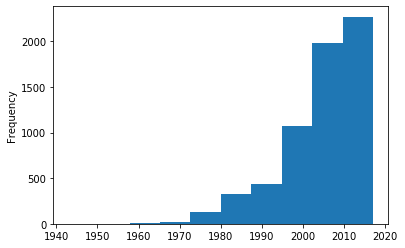

In [134]:
count_user_year['pub_year'].plot.hist()

In [148]:
test2 = pd.pivot_table(count_user_year, index='user_idx', columns= 'pub_year', values='year_count')

# Print the number of dimensions and a subset of the dataset
print('dataset dimensions: ', test2.shape, '\n\nSubset example:')
test2.iloc[:6, :10]

dataset dimensions:  (404, 56) 

Subset example:


pub_year,1943.0,1944.0,1956.0,1961.0,1963.0,1964.0,1965.0,1966.0,1968.0,1970.0
user_idx,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
test2.fillna(0, inplace=True)

In [154]:
test2.shape

(404, 56)

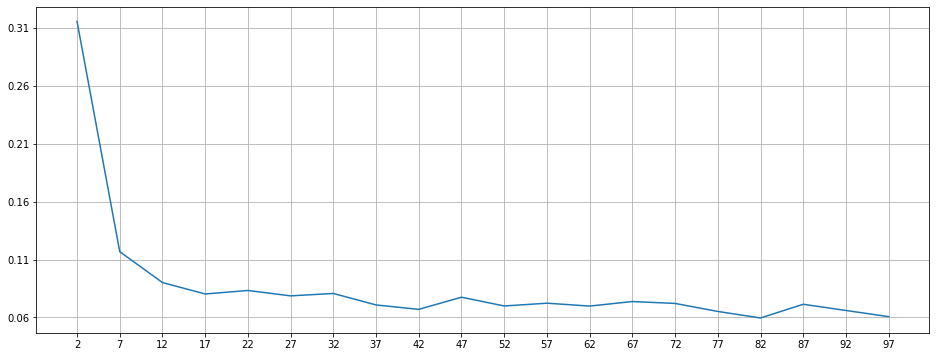

In [156]:
# Selecting our dataset to study
X = test2
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) 
    #for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values[:20], errors_per_k[:20])
# Ticks and grid
xticks = np.arange(min(possible_k_values[:20]), max(possible_k_values[:20])+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k[:20]), 2), max(errors_per_k[:20]), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [222]:
# 20 clusters
predictions = KMeans(n_clusters=10).fit_predict(test2)

# Cluster and print some of them
clustered = pd.concat([user_book_year.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [223]:
print(set(clustered['group'].values))
Counter(predictions)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Counter({9: 52, 0: 45, 4: 91, 5: 65, 6: 16, 3: 63, 2: 28, 1: 20, 7: 8, 8: 16})

## Clustering with book years and book main subgenre

In [161]:
user_gp14_filtered.head(4)

,user_idx,book_idx,popular_shelves,pub_year
0,0,624,fantasy,2002.0
4,0,3473,urban-fantasy,2008.0
5,0,4001,fantasy,2009.0
9,0,273,fantasy,1973.0


In [162]:
count_user_tag = user_gp14_filtered.groupby(['user_idx', 'popular_shelves']).size().reset_index(name ='tag_count')

In [179]:
count_user_tag.head(5)

,user_idx,popular_shelves,tag_count
0,0,comics,17
1,0,dystopian,1
2,0,fantasy,12
3,0,fiction,10
4,0,graphic-novels,14


In [165]:
len(user_gp14_filtered[(user_gp14_filtered['user_idx'] == 0) & (user_gp14_filtered['popular_shelves'] == 'comics')])

17

In [175]:
print('The number of unique tags is %d' %len(set(count_user_tag.popular_shelves)))

The number of unique tags is 198


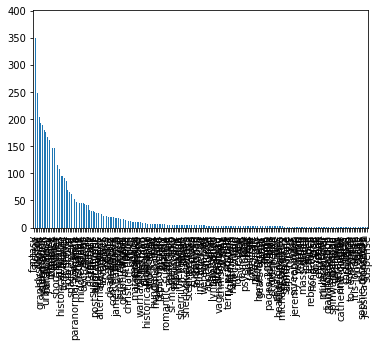

In [186]:
count_user_tag['popular_shelves'].value_counts().plot(kind='bar')

In [192]:
test2.head(4)

pub_year,1943.0,1944.0,1956.0,1961.0,1963.0,1964.0,1965.0,1966.0,1968.0,1970.0,...,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,5.0,4.0,15.0,5.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,10.0,10.0,4.0,5.0,1.0,1.0,3.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
listtags = Counter(count_user_tag['popular_shelves'])

In [206]:
listtags_freq = [k for k,v in listtags.items() if v>=10]

In [208]:
df_u_tags = count_user_tag[count_user_tag['popular_shelves'].isin(listtags_freq)]

In [209]:
df_u_tags.head(5)

,user_idx,popular_shelves,tag_count
0,0,comics,17
1,0,dystopian,1
2,0,fantasy,12
3,0,fiction,10
4,0,graphic-novels,14


In [210]:
test3 = pd.pivot_table(df_u_tags, index='user_idx', columns= 'popular_shelves', values='tag_count')

In [211]:
test3.head()

popular_shelves,adventure,aliens,alternate-history,angels,apocalyptic,bizarro,childhood,christian-fiction,classic,comics,...,superheroes,supernatural,thriller,time-travel,urban-fantasy,vampires,wake,warhammer-40k,young-adult,zombies
user_idx,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,...,1.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,1.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [212]:
test2.head()

pub_year,1943.0,1944.0,1956.0,1961.0,1963.0,1964.0,1965.0,1966.0,1968.0,1970.0,...,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,5.0,4.0,15.0,5.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,10.0,10.0,4.0,5.0,1.0,1.0,3.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,5.0,3.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0


In [213]:
tag_year = pd.merge(test2, test3, on='user_idx',)

In [216]:
tag_year.fillna(0, inplace=True)
tag_year.head(3)

,1943.0,1944.0,1956.0,1961.0,1963.0,1964.0,1965.0,1966.0,1968.0,1970.0,...,superheroes,supernatural,thriller,time-travel,urban-fantasy,vampires,wake,warhammer-40k,young-adult,zombies
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [217]:
tag_year.shape

(404, 120)

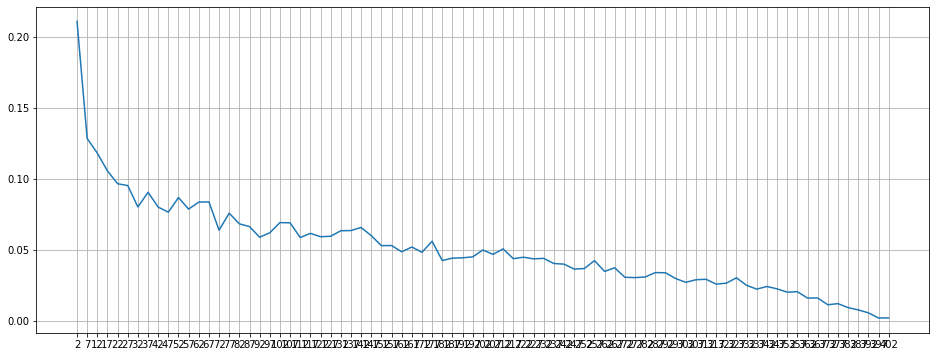

In [219]:
# Selecting our dataset to study
X = tag_year
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) 
    #for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg


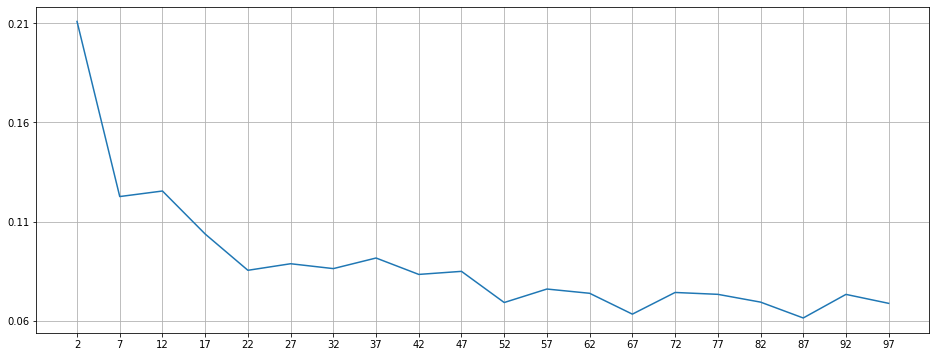

In [224]:

# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values[:20], errors_per_k[:20])
# Ticks and grid
xticks = np.arange(min(possible_k_values[:20]), max(possible_k_values[:20])+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k[:20]), 2), max(errors_per_k[:20]), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [248]:
# 20 clusters
predictions = KMeans(n_clusters=12).fit_predict(tag_year)

# Cluster and print some of them
clustered_k12 = pd.concat([tag_year.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [249]:
print(set(clustered_k12['group'].values))
Counter(predictions)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}


Counter({1: 23,
         10: 31,
         9: 73,
         3: 61,
         7: 14,
         2: 43,
         6: 41,
         5: 26,
         11: 21,
         8: 5,
         4: 24,
         0: 42})

In [252]:
# 20 clusters
predictions = KMeans(n_clusters=7).fit_predict(tag_year)

# Cluster and print some of them
clustered_k7 = pd.concat([tag_year.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
print(set(clustered_k7['group'].values))
Counter(predictions)

{0, 1, 2, 3, 4, 5, 6}


Counter({1: 36, 3: 30, 0: 111, 4: 95, 6: 40, 5: 61, 2: 31})

## Now sub-clustering from each main clustering previously identified

In [22]:
user_clustid.head(3)

,user_idx,group
0,0,14
1,1,14
2,2,14


In [23]:
count_user_clust = user_clustid.groupby(['group']).size().reset_index(name ='gp_count')

In [74]:
count_user_clust

,group,gp_count
0,0,1
1,1,1
2,2,3
3,3,1
4,4,211
5,5,1
6,6,1
7,7,1
8,8,1
9,9,1


## Now testing with all groups with more than 10 users

In [31]:
def clust_group(dfin, clustid):
    df_clust = dfin[dfin['group'] == clustid]
    df_clust_filtered = df_clust.drop(df_clust.columns[[1, 2, 3, 4, 5, 6, 7, 8, 10]], axis=1)  
    
    count_user_year = df_clust_filtered.groupby(['user_idx', 'pub_year']).size().reset_index(name ='year_count')
    user_year_pivot = pd.pivot_table(count_user_year, index='user_idx', columns= 'pub_year', values='year_count')
    
    count_user_tag = df_clust_filtered.groupby(['user_idx', 'popular_shelves']).size().reset_index(name ='tag_count')
    listtags = Counter(count_user_tag['popular_shelves'])
    listtags_freq = [k for k,v in listtags.items() if v>=10]
    df_u_tags = count_user_tag[count_user_tag['popular_shelves'].isin(listtags_freq)]
    user_tag_pivot = pd.pivot_table(df_u_tags, index='user_idx', columns= 'popular_shelves', values='tag_count')

    tag_year = pd.merge(user_year_pivot, user_tag_pivot, on='user_idx')
    tag_year.fillna(0, inplace=True)

    return tag_year


In [73]:
len(user_all[user_all['group'] == 4])

15446

In [33]:
tag_year_gp4 = clust_group(user_all, 4)

In [34]:
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

## Cluster 4

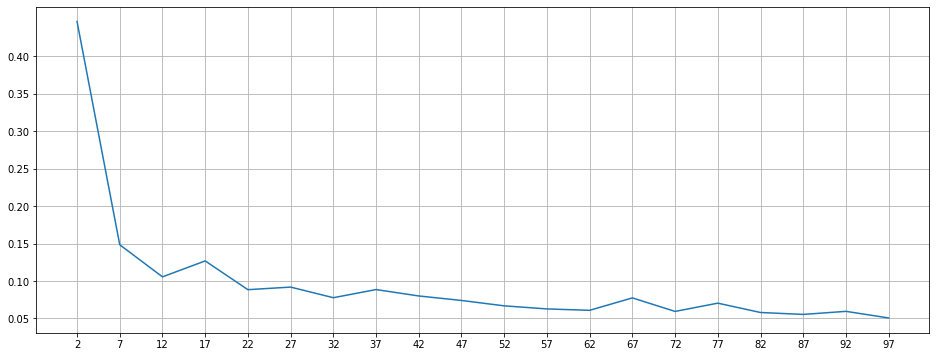

In [35]:
# Selecting our dataset to study
X = tag_year_gp4
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
    
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values[:20], errors_per_k[:20])
# Ticks and grid
xticks = np.arange(min(possible_k_values[:20]), max(possible_k_values[:20])+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k[:20]), 2), max(errors_per_k[:20]), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [99]:
predictions_gp4 = KMeans(n_clusters=12).fit_predict(tag_year_gp4)

# Cluster and print some of them
clustered_gp4 = pd.concat([tag_year_gp4.reset_index(), pd.DataFrame({'group':predictions_gp4})], axis=1)
Counter(predictions_gp4)

Counter({1: 35,
         4: 60,
         3: 4,
         7: 18,
         5: 9,
         0: 6,
         2: 29,
         9: 8,
         11: 19,
         10: 15,
         8: 4,
         6: 4})

In [96]:
predictions2 = KMeans(n_clusters=7).fit_predict(tag_year_gp4)

# Cluster and print some of them
clustered_gp4b = pd.concat([tag_year_gp4.reset_index(), pd.DataFrame({'group':predictions2})], axis=1)
Counter(predictions2)

Counter({6: 61, 5: 60, 4: 14, 0: 9, 2: 14, 1: 48, 3: 5})

## Cluster 11

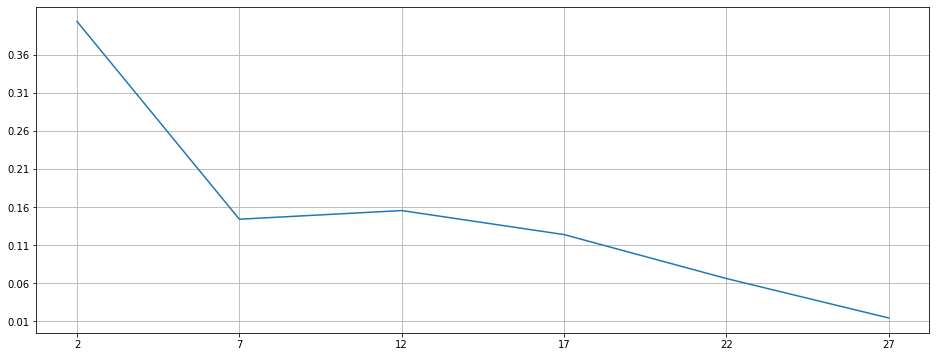

In [37]:
tag_year_gp11 = clust_group(user_all, 11)
# Selecting our dataset to study
X = tag_year_gp11
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
    
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [103]:
predictions_gp11 = KMeans(n_clusters=2).fit_predict(tag_year_gp11)

# Cluster and print some of them
clustered_gp11 = pd.concat([tag_year_gp11.reset_index(), pd.DataFrame({'group':predictions_gp11})], axis=1)
Counter(predictions_gp11)

Counter({0: 23, 1: 5})

## Cluster 12

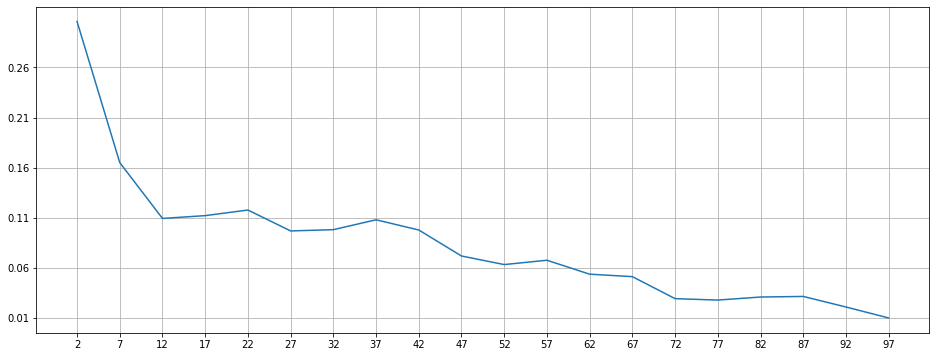

In [39]:
tag_year_gp12 = clust_group(user_all, 12)
# Selecting our dataset to study
X = tag_year_gp12
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
    
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [105]:
predictions_gp12 = KMeans(n_clusters=7).fit_predict(tag_year_gp12)

# Cluster and print some of them
clustered_gp12 = pd.concat([tag_year_gp12.reset_index(), pd.DataFrame({'group':predictions_gp12})], axis=1)
Counter(predictions_gp12)

Counter({3: 25, 4: 24, 0: 19, 1: 6, 6: 12, 5: 1, 2: 13})

## Cluster 14

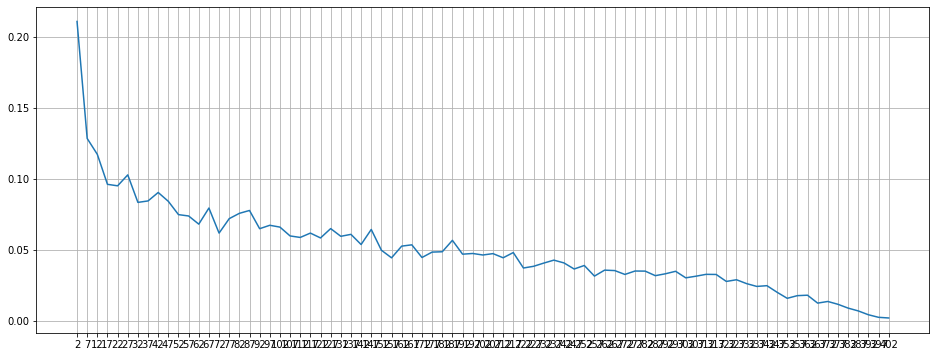

In [94]:
tag_year_gp14 = clust_group(user_all, 14)
# Selecting our dataset to study
X = tag_year_gp14
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, X.shape[0]+1, 5)
    
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

In [95]:
predictions = KMeans(n_clusters=7).fit_predict(tag_year_gp14)

# Cluster and print some of them
clustered_gp14 = pd.concat([tag_year_gp14.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
Counter(predictions)

Counter({0: 44, 6: 37, 1: 116, 2: 96, 4: 34, 3: 37, 5: 40})

In [115]:
predictions_gp14 = KMeans(n_clusters=12).fit_predict(tag_year_gp14)

# Cluster and print some of them
clustered_gp14 = pd.concat([tag_year_gp14.reset_index(), pd.DataFrame({'group':predictions_gp14})], axis=1)
Counter(predictions_gp14)

Counter({7: 42,
         2: 31,
         0: 77,
         6: 66,
         10: 20,
         8: 27,
         4: 44,
         9: 23,
         3: 18,
         11: 36,
         1: 14,
         5: 6})

In [117]:
predictions_gp14a = KMeans(n_clusters=12).fit_predict(tag_year_gp14)

# Cluster and print some of them
clustered_gp14a = pd.concat([tag_year_gp14.reset_index(), pd.DataFrame({'group':predictions_gp14a})], axis=1)
Counter(predictions_gp14a)

Counter({9: 19,
         8: 30,
         3: 50,
         5: 50,
         2: 26,
         11: 36,
         7: 42,
         6: 59,
         0: 25,
         10: 21,
         1: 40,
         4: 6})

## Testing some clusters

In [67]:
clustered_gp4.describe()
clustered_gp4.columns = clustered_gp4.columns.map(str)

In [81]:
clustered_gp4.shape

(211, 109)

In [68]:
sum_gp4 = clustered_gp4.sum(axis=0)

In [69]:
df_sum_gp4 = pd.DataFrame({'Feature':sum_gp4.index, 'Count': sum_gp4.values})

In [70]:
df_sum_gp4.head(5)

,Feature,Count
0,user_idx,82390.0
1,1937.0,2.0
2,1943.0,2.0
3,1944.0,1.0
4,1956.0,1.0


In [72]:
df_sum_gp4.describe()

,Count
count,109.000000
mean,1047.944954
std,7890.109761
min,1.000000
25%,18.000000
50%,91.000000
75%,258.000000
max,82390.000000


In [82]:
df_sum_gp4_sup100 = df_sum_gp4[df_sum_gp4['Count'] > 100]

In [84]:
df_sum_gp4.shape

(109, 2)

In [86]:
df_sum_gp4_sup100

,Feature,Count
0,user_idx,82390.0
26,1986.0,161.0
27,1987.0,108.0
31,1991.0,132.0
32,1992.0,101.0
34,1994.0,155.0
35,1995.0,197.0
36,1996.0,154.0
37,1997.0,243.0
38,1998.0,235.0


In [261]:
Counter(clustered_gp4['group'])

Counter({11: 38,
         0: 64,
         1: 7,
         5: 10,
         4: 7,
         3: 19,
         7: 27,
         2: 8,
         9: 21,
         10: 4,
         8: 3,
         6: 3})

In [87]:
clustered_gp11.columns = clustered_gp11.columns.map(str)
clustered_gp11.shape

(28, 58)

In [88]:
sum_gp11 = clustered_gp11.sum(axis=0)
df_sum_gp11 = pd.DataFrame({'Feature':sum_gp11.index, 'Count': sum_gp11.values})
df_sum_gp11.describe()

,Count
count,58.000000
mean,274.689655
std,1357.170266
min,1.000000
25%,4.500000
50%,26.000000
75%,87.750000
max,10340.000000


In [91]:
df_sum_gp11_sup100 = df_sum_gp11[df_sum_gp11['Count'] > 50]
df_sum_gp11_sup100

,Feature,Count
0,user_idx,10340.0
25,2006.0,65.0
26,2007.0,91.0
27,2008.0,74.0
28,2009.0,103.0
29,2010.0,251.0
30,2011.0,443.0
31,2012.0,830.0
32,2013.0,450.0
33,2014.0,219.0


##  Saving out the data for each cluster

From step one: keeping 2, 10, 13 and 20

In [93]:
user_clustid.head(5)

,user_idx,group
0,0,14
1,1,14
2,2,14
3,3,4
4,4,14


From step two, cluster 4 (pop 211) leads to 12 clusters

In [100]:
Counter(predictions_gp4)

Counter({1: 35,
         4: 60,
         3: 4,
         7: 18,
         5: 9,
         0: 6,
         2: 29,
         9: 8,
         11: 19,
         10: 15,
         8: 4,
         6: 4})

In [119]:
sum((Counter(predictions_gp4).values()))

211

From step two, cluster 11 (pop 28) leads to 2 clusters

In [104]:
Counter(predictions_gp11)

Counter({0: 23, 1: 5})

Cluster 12 to 7 clusters

In [107]:
Counter(predictions_gp12)

Counter({3: 25, 4: 24, 0: 19, 1: 6, 6: 12, 5: 1, 2: 13})

Cluster 14 to 12 clusters

In [118]:
Counter(predictions_gp14a)

Counter({9: 19,
         8: 30,
         3: 50,
         5: 50,
         2: 26,
         11: 36,
         7: 42,
         6: 59,
         0: 25,
         10: 21,
         1: 40,
         4: 6})

Saving all the clusters

In [120]:
clust1 = user_clustid[user_clustid['group'] == 2]
len(clust1)

3

In [123]:
clust1['group'] = clust1['group'].map({2: 1})

/Users/yasminechebaro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [126]:
clust2 = user_clustid[user_clustid['group'] == 10]
clust2['group'] = clust2['group'].map({10: 2})
len(clust2)

/Users/yasminechebaro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


5

In [273]:
clust3 = user_clustid[user_clustid['group'] == 13]
clust3['group'] = clust3['group'].map({13: 3})
len(clust3)

/Users/yasminechebaro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


9

In [128]:
clust4 = user_clustid[user_clustid['group'] == 20]
clust4['group'] = clust4['group'].map({20: 4})
len(clust4)

/Users/yasminechebaro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


10

In [264]:
def get_clusters_prop(dfcluster, start):
    dfclean = dfcluster.copy()
    
    # count the number of groups
    count = len(dfclean.groupby('group').count())
    
    # renumber group id according to start 
    for i in range(count):
        dfclean['new_group'] = dfclean['group']+start

    dfclean['new_group'] = dfclean['new_group'].astype(int)
        
    # do some cleaning
    dfclean.drop('group', axis=1, inplace=True)
    dfclean.rename(columns={'user_idx': 'user_idx', 'new_group': 'group'}, inplace=True)
        
    return dfclean

In [265]:
clust5 = get_clusters_prop(clustered_gp4.loc[:, ['user_idx','group']], 5)

In [267]:
clust6 = get_clusters_prop(clustered_gp11.loc[:, ['user_idx','group']], 17)

In [268]:
clust7 = get_clusters_prop(clustered_gp12.loc[:, ['user_idx','group']], 19)

In [277]:
clust8 = get_clusters_prop(clustered_gp14a.loc[:, ['user_idx','group']], 26)

In [278]:
test = pd.concat([clust1, clust2, clust3, clust4, clust5, clust6, clust7, clust8], ignore_index=True)

In [275]:
test.head()

,user_idx,group
0,200,1
1,395,1
2,530,1
3,81,2
4,458,2


In [279]:
test.groupby('group').count()

,user_idx
group,
1,3
2,5
3,9
4,10
5,6
6,35
7,29
8,4
9,60


In [284]:
len(count_user_clust[count_user_clust['gp_count'] == 1])

17

In [282]:
len(count_user_clust)

25

In [283]:
count_user_clust

,group,gp_count
0,0,1
1,1,1
2,2,3
3,3,1
4,4,211
5,5,1
6,6,1
7,7,1
8,8,1
9,9,1


In [286]:
count_user_clust_new = test.groupby(['group']).size().reset_index(name ='gp_count')

In [287]:
count_user_clust_new

,group,gp_count
0,1,3
1,2,5
2,3,9
3,4,10
4,5,6
5,6,35
6,7,29
7,8,4
8,9,60
9,10,9


In [288]:
test.head(5)

,user_idx,group
0,200,1
1,395,1
2,530,1
3,81,2
4,458,2


In [289]:
final = test[test['group'] != 24]

In [291]:
count_user_clust_final = final.groupby(['group']).size().reset_index(name ='gp_count')

In [297]:
#count_user_clust_final

In [293]:
# get clusters with at least 10 users
sup10 = count_user_clust_final[count_user_clust_final['gp_count'] >= 10]

In [295]:
listsup10 = sup10['gp_count'].to_list()

In [298]:
final_sup10 = final[final['group'].isin(listsup10)]

In [299]:
final_sup10.to_csv('clusters_final.csv', index=False)